In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def relu3(x):
    return tf.where(x <= 0, 0, x**3)

# differential equation 
# y'' = x, y(0) = 0, y(1) = 0
def x_true_y(t):
    return(1/6)*t*((t**2)-1)

# differential equation 
# y'' = sqrtx, y(0) = 0, y(1) = 0
def sqrt_true_y(t):
    return (4/15)*t*((t**(3/2))-1)

# differential equation 
# y'' = sinx, y(0) = 0, y(1) = 0
def sin_true_y(t):
    return t*np.sin(1) - np.sin(t)


class ODENet_Shallow(tf.keras.Model):
    def __init__(self, layer1params = 100):
        super(ODENet_Shallow, self).__init__()
        layer1_parameters = layer1params
        self.dense1 = tf.keras.layers.Dense(layer1_parameters, activation=relu3, kernel_initializer = 'random_normal')
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)
    
class ODENet_Deep(tf.keras.Model):
    def __init__(self, layer1params = 100, layer2params = 100):
        super(ODENet_Deep, self).__init__()
        layer1_parameters = layer1params
        layer2_parameters = layer2params
        self.dense1 = tf.keras.layers.Dense(layer1_parameters, activation=relu3)
        self.dense2 = tf.keras.layers.Dense(layer2_parameters, activation=relu3)
        self.dense3 = tf.keras.layers.Dense(1)
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)
    
model = ODENet_Shallow(1000)

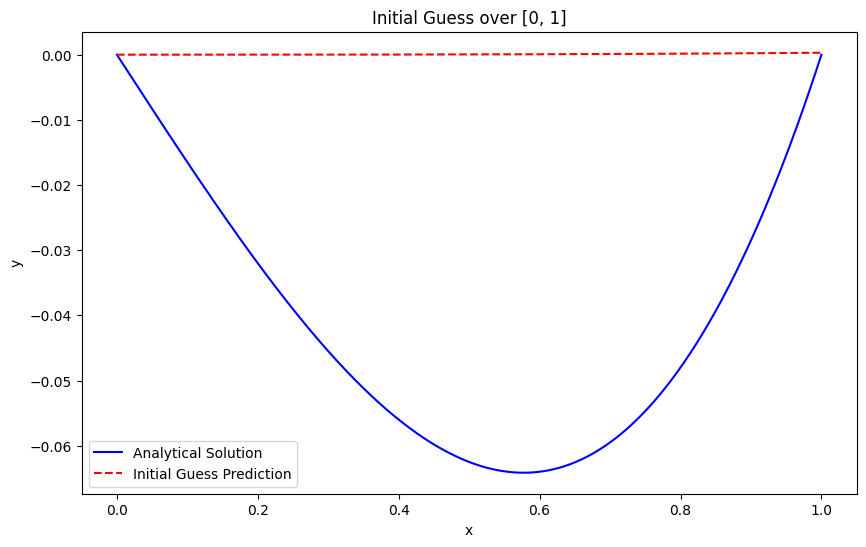

In [35]:
#initial guess

test_n = 1000
x_test = np.linspace(0, 1, test_n).reshape(-1, 1)
y_true = x_true_y(x_test)
y_pred = model(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='Analytical Solution', color='blue')
plt.plot(x_test, y_pred, label='Initial Guess Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial Guess over [0, 1]')
plt.show()

In [36]:
# differential equation 
# y'' = x, y(0) = 0, y(1) = 0
def f(x):
    return x

# differential equation 
# y'' = sinx, y(0) = 0, y(1) = 0
def sin(x):
    return np.sin(x)

# differential equation 
# y'' = sqrtx, y(0) = 0, y(1) = 0
def sqrt(x):
    return np.sqrt(x)

def loss_fn(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = model(x)
        dy_dx = tape.gradient(y, x)
        d2y_dx2 = tape.gradient(dy_dx, x)

    # Residual from the differential equation
    residual = d2y_dx2 - f(x)

    # Calculate the loss as the squared error
    loss = tf.reduce_mean(tf.square(residual))

    # Add boundary conditions to the loss
    loss += 0.5 * tf.square(model(tf.constant([[0.0]], dtype=tf.float32)))
    loss += 0.5 * tf.square(model(tf.constant([[1.0]], dtype=tf.float32)))
    
    return loss

In [37]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, x)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
        #weights = model.trainable_weights
    return loss

num_training_points = 1000
x_samples = tf.convert_to_tensor(np.linspace(0, 1, num_training_points).reshape(-1, 1), dtype=tf.float32)

In [41]:
epochs = 1000
x_linespace = np.linspace(0, 1, test_n).reshape(-1, 1)
for step in range(epochs):
    if step % 100 == 0:
        plt.figure(figsize=(10, 6))
        plt.plot(x_linespace, x_true_y(x_linespace), label='Analytical/True Solution', color='blue')
        plt.plot(x_linespace, model(x_linespace), label='Prediction', color='red', linestyle='--')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.title('Model Guess over [0, 1]')
    
        filename = f'plot_{step}.png'
        plt.savefig(filename)
        print('plot saved')
        plt.close()
    loss= train_step(model, x_samples)
    if step % 100 == 0:
        print(f"Step: {step}, Loss: {loss.numpy()}")
    

plot saved
Step: 0, Loss: [[0.00642886]]
plot saved
Step: 100, Loss: [[0.00642858]]


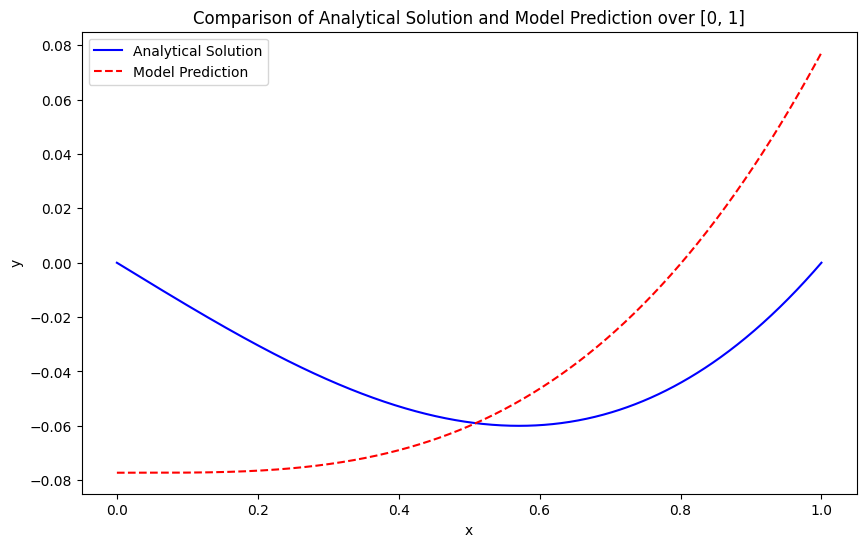

In [26]:
test_n = 1000
x_test = np.linspace(0, 1, test_n).reshape(-1, 1)
y_true = x_true_y(x_test)
y_pred = model(x_test)

plt.figure(figsize=(10, 6))
plt.plot(x_test, y_true, label='Analytical Solution', color='blue')
plt.plot(x_test, y_pred, label='Model Prediction', color='red', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Comparison of Analytical Solution and Model Prediction over [0, 1]')
plt.show()

In [18]:
max_error_array = np.absolute(y_true - y_pred)
max_error = np.max(max_error_array)
max_error

0.07724844

In [98]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

max_error_array = np.array([])
final_loss_array = np.array([])
parameters_count_array = np.array([])

for i in range(1,20):
    width = i*100
    network = ODENet_Shallow(width)
    
    num_training_points = 1000

    x_samples = tf.convert_to_tensor(np.linspace(0, 1, num_training_points).reshape(-1, 1), dtype=tf.float32)
    
    epochs = 1000
    for step in range(epochs):
        loss = train_step(network, x_samples)
    
    test_n = 1000
    x_test = np.linspace(0, 1, test_n).reshape(-1, 1)
    y_true = sin_true_y(x_test)
    y_pred = network(x_test)
    
    error_array = np.absolute(y_true - y_pred)
    max_error = np.max(error_array)
    max_error_array = np.append(max_error_array, max_error)
    final_loss_array = np.append(final_loss_array, loss)
    parameters_count_array = np.append(parameters_count_array, width*2)

In [99]:
final_loss_array

array([0.00611608, 0.00611608, 0.00611608, 0.00611608, 0.00582993,
       0.00581781, 0.00611608, 0.00611602, 0.00611608, 0.00611605,
       0.00611608, 0.00611608, 0.00611608, 0.12961935, 0.00611608,
       0.00611608, 0.00611608, 0.0061161 , 0.27275708])

In [100]:
loss = final_loss_array
params = parameters_count_array
error = max_error_array

In [101]:
loss

array([0.00611608, 0.00611608, 0.00611608, 0.00611608, 0.00582993,
       0.00581781, 0.00611608, 0.00611602, 0.00611608, 0.00611605,
       0.00611608, 0.00611608, 0.00611608, 0.12961935, 0.00611608,
       0.00611608, 0.00611608, 0.0061161 , 0.27275708])

In [102]:
params

array([ 200.,  400.,  600.,  800., 1000., 1200., 1400., 1600., 1800.,
       2000., 2200., 2400., 2600., 2800., 3000., 3200., 3400., 3600.,
       3800.])

In [103]:
error

array([0.07323666, 0.07323666, 0.07323666, 0.07323667, 0.07344858,
       0.07346185, 0.07323668, 0.07323676, 0.07323668, 0.07323671,
       0.07323666, 0.07323666, 0.07323667, 0.14299272, 0.07323666,
       0.07323668, 0.07323661, 0.07323664, 0.05999374])

In [104]:
import pandas as pd

df = pd.DataFrame()
df['num_parameters'] = params
df['final loss'] = loss
df['max_error'] = error 

df

df.to_csv('sinxrelu3shallow.csv')